# LSTM usage example: Energy consumption.

## 0. Required libraries

#### Data manipulation :
- pandas: For data manipulation and analysis.
- numpy: For mathematical calculations and multidimensional tables.

#### Data visualization :
- matplotlib: For plotting graphs.
- seaborn (optional): For enhanced visualizations (if used).

#### Machine learning and Deep Learning :
- tensorflow: For creating and training the LSTM model.
- scikit-learn: For data pre-processing (normalization, metrics, etc.).

#### Date and time series management:
- datetime: for manipulating dates.
- dateutil (often included with Pandas): For parsing complex dates.

In [121]:
#Let's use matplotlib
import matplotlib.pyplot as plt
#To see the graphs directly in the notebook (plt.show() is useless):
%matplotlib inline 

#Let's use TensorFlow 1.x in a TensorFlow 2.x environment:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

#Other librairies
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

#To handle errors / exceptions / arguments:
import sys

## 1. Preprocessing

### 1.1 Loading data in csv format

Colums used from "6mois.csv" (6 months of consumption):
- Date and time (UTC) 
- Air Temperature (ºC)
- Total electricity consumption (kWh)
- Zone1 electricity consumption (kWh)
- Zone2 electricity consumption (kWh)

In [122]:
df = pd.read_csv('../data/6mois.csv', usecols=[0,1,6,7,8], index_col=0, parse_dates=True)
df.head()

,Air Temperature (ºC),Total electricity consumption (kWh),Zone1 electricity consumption (kWh),Zone2 electricity consumption (kWh)
Date and time (UTC),,,,
2016-07-15 00:00:00+00:00,12.574,11.145,0.715,2.371
2016-07-15 00:05:00+00:00,12.564,10.599,1.374,1.842
2016-07-15 00:10:00+00:00,12.546,7.471,0.715,2.321
2016-07-15 00:15:00+00:00,12.534,9.906,1.373,1.869
2016-07-15 00:20:00+00:00,12.464,9.419,0.714,2.400


#### 1.2 Resampling every 15 minutes

In [123]:
#We'll use the mean value every 15min
df = df.resample('15Min').mean()
df.head()

,Air Temperature (ºC),Total electricity consumption (kWh),Zone1 electricity consumption (kWh),Zone2 electricity consumption (kWh)
Date and time (UTC),,,,
2016-07-15 00:00:00+00:00,12.561333,9.738333,0.934667,2.178000
2016-07-15 00:15:00+00:00,12.464000,9.416333,0.933333,2.030333
2016-07-15 00:30:00+00:00,12.278667,9.039333,1.154000,2.195667
2016-07-15 00:45:00+00:00,12.316000,9.280667,0.932667,2.074333
2016-07-15 01:00:00+00:00,12.382667,9.884000,0.929667,2.102667


#### 1.3 Extracting information from the date

From the date (column 0 of the dataframe), we create the new features: day of the week, day of the year, hour of the day, etc. 

##### Why extract this information?

1. Seasonality and cycles:
These new time columns capture seasonal, weekly or hourly patterns in energy consumption.

2. Improved model performance:
These variables can be used as additional features for the LSTM model, as they provide important information on temporal variability.

3. Identification of temporal patterns:
For example, electricity consumption may be higher in the morning or at the end of the day, and this information can help to better predict demand.

In [124]:
df['day of the week'] = df.index.dayofweek
df['day of the year'] = df.index.dayofyear
df['hour of the day'] = df.index.hour
df['number of the week'] = df.index.isocalendar().week
df['minute of the hour'] = df.index.minute

In [125]:
df.head()

,Air Temperature (ºC),Total electricity consumption (kWh),Zone1 electricity consumption (kWh),Zone2 electricity consumption (kWh),day of the week,day of the year,hour of the day,number of the week,minute of the hour
Date and time (UTC),,,,,,,,,
2016-07-15 00:00:00+00:00,12.561333,9.738333,0.934667,2.178000,4,197,0,28,0
2016-07-15 00:15:00+00:00,12.464000,9.416333,0.933333,2.030333,4,197,0,28,15
2016-07-15 00:30:00+00:00,12.278667,9.039333,1.154000,2.195667,4,197,0,28,30
2016-07-15 00:45:00+00:00,12.316000,9.280667,0.932667,2.074333,4,197,0,28,45
2016-07-15 01:00:00+00:00,12.382667,9.884000,0.929667,2.102667,4,197,1,28,0


#### 1.4 Selecting features and labels

After loading and modifying the data, select features and labels.
There are several types of prediction:
- One to One: One input corresponds to one output, for example, predicting electricity consumption for a given moment based on data at that same moment.

- One to Many :
One input corresponds to several outputs, such as predicting several future electricity consumption values from past data.

- Many to One :
Several inputs (past data) are used to predict a single future output, such as using past consumption to predict future consumption at a given point in time.

- Many to Many :
Several inputs are used to predict several future outputs, for example, predicting electricity consumption for several future points in time from past data.

In the following, we'll focus on the Many-to-One case.

- Label (to predict): 'Total electricity consumption (kW)'.
- Features: 'Air Temperature (ºC)', 'day of the week', 'hour of the day', 'minute of the hour', 'number of the week'.

In [126]:
features = ['Air Temperature (ºC)', 'day of the week', 'hour of the day', 'minute of the hour', 'number of the week']
labels   = ['Total electricity consumption (kWh)']
inputs   = features + labels

In [127]:
df = df[inputs]

shift_days = 1
shift_steps = shift_days
df_targets = np.roll(df[labels],-shift_steps)

#### 1.5 Perform data normalization using MinMaxScaler()

In [128]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)
df_scaled.head()

,Air Temperature (ºC),day of the week,hour of the day,minute of the hour,number of the week,Total electricity consumption (kWh)
Date and time (UTC),,,,,,
2016-07-15 00:00:00+00:00,0.435434,0.666667,0.000000,0.000000,0.529412,0.097973
2016-07-15 00:15:00+00:00,0.433036,0.666667,0.000000,0.333333,0.529412,0.094734
2016-07-15 00:30:00+00:00,0.428471,0.666667,0.000000,0.666667,0.529412,0.090941
2016-07-15 00:45:00+00:00,0.429390,0.666667,0.000000,1.000000,0.529412,0.093369
2016-07-15 01:00:00+00:00,0.431033,0.666667,0.043478,0.000000,0.529412,0.099439


#### 1.6 Displaying total building consumption in a graph

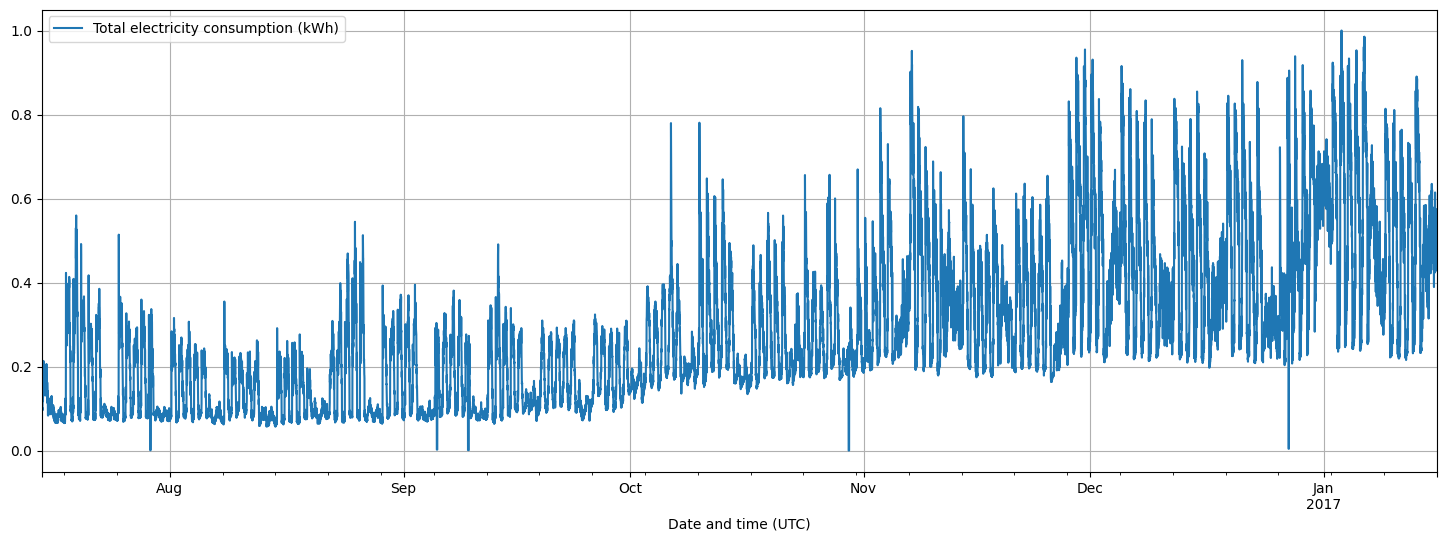

In [129]:
fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(111)
df_scaled[labels].plot(ax=ax)
plt.grid(True)
plt.show()

#### 1.7 Creating training and test data
Create the split_data function, which takes as input the data and size of the test data and returns two dataframes (df_train and df_test)

In [130]:
def split_data(data, test_size=0.25):
    """
    splits data to training and testing parts
    """
    ntest = int(round(len(data) * (1 - test_size)))
    
    df_train, df_test = data.iloc[:ntest], data.iloc[ntest:]
    
    return df_train, df_test


In [131]:
df_train, df_test = split_data(df_scaled, test_size=0.25)

x_train_scaled = np.asarray(df_train[features])
x_test_scaled = np.asarray(df_test[features])
y_test_scaled = np.asarray(df_test[labels])
y_train_scaled = np.asarray(df_train[labels])

num_test = len(df_test)
num_train = len(df_train)
num_total = len(df)

print(f'Total data length (number of lines): \t\t\t{len(df)}\n'+
f'Total length of test data (number of lines):\t\t{len(df_test)}\n'+
f'Total length of training data (number of lines): \t{len(df_train)}')


Total data length (number of lines): 			17761
Total length of test data (number of lines):		4440
Total length of training data (number of lines): 	13321


#### 1.8 Displaying training and test data in a graph

<Axes: title={'center': 'Test data'}, xlabel='Date and time (UTC)'>

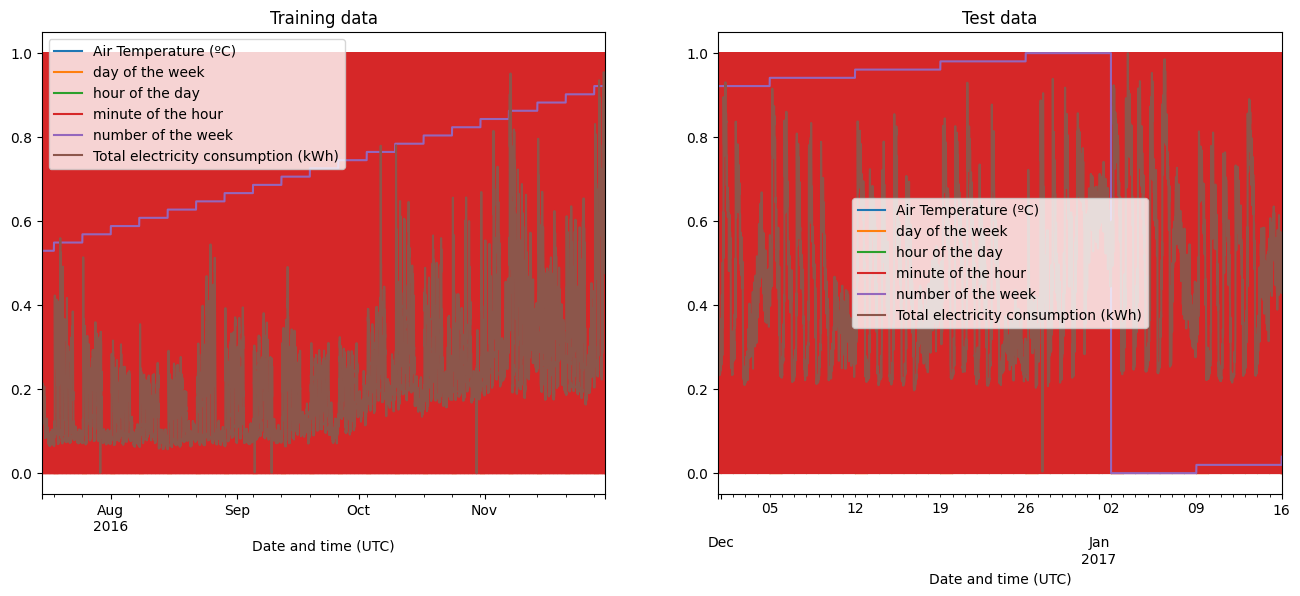

In [132]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

df_train.plot(ax=ax1, title="Training data")
df_test.plot(ax=ax2, title="Test data")

In [133]:
num_features = len(features)
num_labels = len(labels)
num_inputs = num_features + num_labels

print(f'Total data length (number of columns): \t\t\t{num_features}\n'+
f'Total length of test data (number of columns): \t\t{num_labels}\n'+
f'Total length of training data (number of columns): \t{num_inputs}')

Total data length (number of columns): 			5
Total length of test data (number of columns): 		1
Total length of training data (number of columns): 	6


# 2. Training & Inference

#### 2.1. Function to create random batches of training and test data 

In [134]:
def batch_generator(batch_size, sequence_length, num_features, num_labels, num_test, x, y):
    """
    Generator function for creating random batches of training data.

    Parameters:
        batch_size (int): Number of samples per batch.
        sequence_length (int): Number of time steps in each sequence.
        num_features (int): Number of input features.
        num_labels (int): Number of output labels.
        num_test (int): Number of samples in test set (used to avoid using test data for training).
        x (numpy.ndarray): Form input data (num_samples, num_features).
        y (numpy.ndarray): Shape labels (num_samples, num_labels).

    Yields :
        tuple: A batch of input data (x_batch) and corresponding labels (y_batch).
    """
    #The while True loop makes it possible to generate infinite batches of data. 
    #It's necessary in generators used to train a model, 
    #since the data is supplied in a continuous stream and the function stops only when training is complete.
    while True:
        # Allocate a new array for the batch of INPUTS filled with zeros.
        # Dimensions = (batch_size, sequence_length, num_features) 
        x_shape = (batch_size, sequence_length, num_features)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)
        
        # Same for OUTPUTS.
        y_shape = (batch_size, sequence_length, num_labels)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        #Fill the batch with random sequences of data from x and y.
        for i in range(batch_size):
            if num_test < sequence_length:
                raise ValueError("There will be  problem: test too short!")
            else:
                # Random starting index for the sequence
                idx = np.random.randint(num_test - sequence_length)

                # Slice the data for this batch sample
                x_batch[i] = x[idx:idx + sequence_length]
                y_batch[i] = y[idx + sequence_length]

        yield (x_batch, y_batch) #yield leaves the function open (contrary to a "return")

Here, we create an input 3D matrix and an output 3D matrix, containing _batch_size_ time sequences, where each sequence has a length of _sequence_length_ and each time step contains either the features or the label.

The INPUT matrix has a shape of (50, 96, 6):
- 50 : Number of sequences (samples in the batch).
- 96: Number of time steps in each sequence.
- 5: Number of features.

The OUTPUT matrix has a shape of (50, 96, 1):
- 50 : Number of sequences (samples in the batch).
- 96: Number of time steps in each sequence.
- 1: THE label.

In [135]:
# Parameter settings
batch_size = 50
sequence_length = int(60 / 15 * 24 * 1) 

# Creation of generator objects for train and test
generator = batch_generator(batch_size, sequence_length, num_features, num_labels, num_train, x_train_scaled, y_train_scaled)
testgenerator = batch_generator(batch_size, sequence_length, num_features, num_labels, num_test, x_test_scaled, y_test_scaled)

# Generate ONE batch
x_batch, y_batch = next(generator)

In [136]:
print(f'Input Batch Shape :  {x_batch.shape}')
print(f'Output Batch Shape :  {y_batch.shape}')

Input Batch Shape :  (50, 96, 5)
Output Batch Shape :  (50, 96, 1)


Text(0.5, 1.0, 'Plot of the first sequence  from batch')

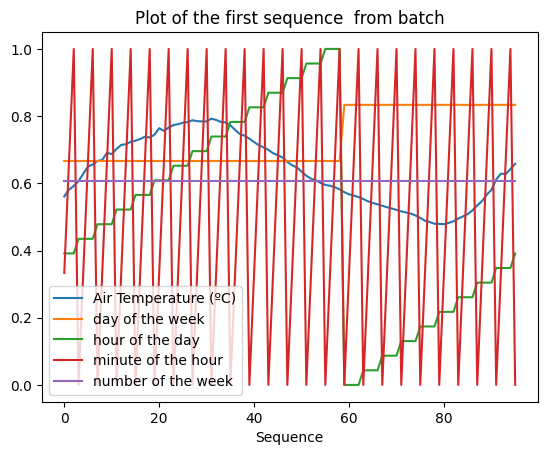

In [137]:
#Extraction of a specific sequence to visualize a batch

#We extract the first sequence, corresponding to index 0 in the batch:
#The result is a 2D matrix of shape (96, 6).
seq = x_batch[0, :, :]

plt.plot(seq)
plt.xlabel('Sequence')
plt.legend(features)
plt.title(f'Plot of the first sequence  from batch')

#### 2.2. Creating the dynamic_RNN model

- Here we choose a _dynamic recurrent neural network_ model. 
- With _num_layers_ LSTM cells and a dense layer.

In [172]:
# Parameter configuration
num_neurons = 200  # Number of neurons per layer
learning_rate = 0.001
num_layers = 4  # Number of LSTM layers
num_iter = 50  # Number of iterations
keep_prob = 0.2  # Dropout rate for regularization
#A high dropout rate reduces overlearning by randomly deactivating certain neurons during training.

In [173]:
# Calling the generator object testgenerator to get a new batch of data.
# The next() function in Python is used to get the next item from an iterable object, such as a list, a generator, or an iterator.
x_batch, y_batch = next(testgenerator)

In [174]:
# Function to create LSTM cells
# It applies dropout regularization to each cell to prevent overfitting.
def create_lstm_cells(num_layers, num_neurons, keep_prob):
    cells = []
    for _ in range(num_layers):
        lstm_cell = tf.nn.rnn_cell.LSTMCell(num_neurons) #Creation of ONE cell
        lstm_cell = tf.nn.rnn_cell.DropoutWrapper(lstm_cell, output_keep_prob=keep_prob) #Droupout to avoid overfitting
        cells.append(lstm_cell)
    return tf.nn.rnn_cell.MultiRNNCell(cells)

#### 2.3. Definition of the model's structure and the operations required to create the TensorFlow graph.

What dynamic_rnn returns:
- outputs: This is the output of the RNN, containing the results for each step in the sequence for each sample in the batch. It is a 3D tensor of the form [batch_size, sequence_length, num_neurons]. Each output element is the output of the LSTMs at a given point in the sequence.

- current_state: This is the final state of the RNN after processing the entire sequence. It represents the hidden state and memory of all LSTM layers at the end of each sequence. It is a tensor containing the internal state of the model after processing the input sequence.

In [175]:
# Create the TensorFlow graph
graph = tf.Graph()

with graph.as_default():    
    # Definition of placeholders for input and output data (= definition of x and y)
    x = tf.placeholder(dtype=tf.float32, shape=[None, sequence_length, num_features], name='x')
    y = tf.placeholder(dtype=tf.float32, shape=[None, sequence_length, num_labels], name='y')

    # Using dynamic RNN to handle variable-length sequences
    lstm_cells = create_lstm_cells(num_layers, num_neurons, keep_prob)
    outputs, current_state = tf.nn.dynamic_rnn(lstm_cells, x, dtype=tf.float32)

    # Flatten the output to 2D tensor (maintaining the num_neurons dimension for each element in the batch):
    stacked_rnn_output = tf.reshape(outputs, [-1, num_neurons])

    # Dense output layer. The output hase these dimensions: [batch_size * sequence_length, num_labels]:
    stacked_outputs = tf.layers.dense(stacked_rnn_output, num_labels)

    #Reshaping output to its original form (batch_size, sequence_length, num_labels):
    outputs = tf.reshape(stacked_outputs, [-1, sequence_length, num_labels])

    # Defining loss function and optimizer
    loss = tf.losses.mean_squared_error(labels=y, predictions=outputs)  # MSE loss function
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)  # Adam optimizer
    train = optimizer.minimize(loss)  # Minimize the loss

    # Initializing variables
    init = tf.global_variables_initializer()

/var/folders/cn/f1c072zn49n5lbvp5frkrh500000gn/T/ipykernel_65143/1541410643.py:6: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  lstm_cell = tf.nn.rnn_cell.LSTMCell(num_neurons) #Creation of ONE cell
/var/folders/cn/f1c072zn49n5lbvp5frkrh500000gn/T/ipykernel_65143/655606597.py:17: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  stacked_outputs = tf.layers.dense(stacked_rnn_output, num_labels)


#### 2.4. Model execution

Iteration 0/50, RMSE: 0.2787744998931885
Iteration 10/50, RMSE: 0.12941749393939972
Iteration 20/50, RMSE: 0.13240240514278412
Iteration 30/50, RMSE: 0.15926535427570343
Iteration 40/50, RMSE: 0.1265014410018921


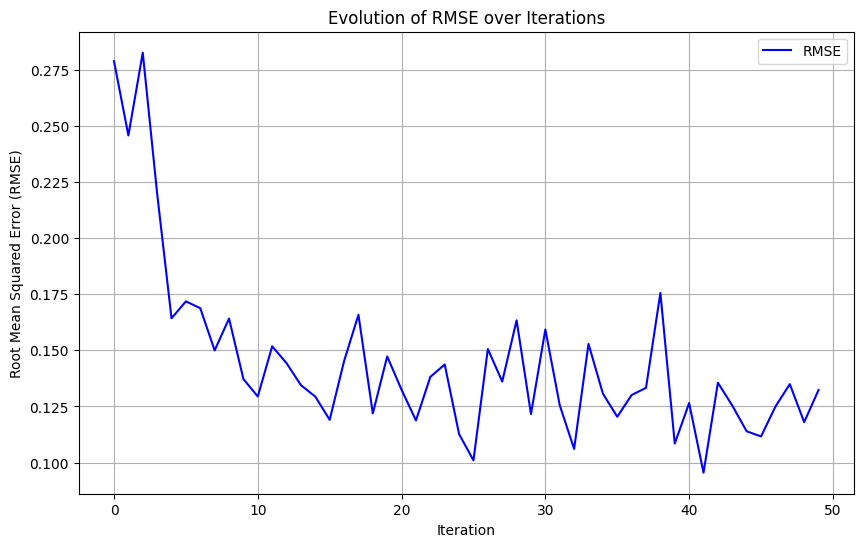

Test Batch 1/100, RMSE: 0.32144543528556824
Test Batch 11/100, RMSE: 0.32587021589279175
Test Batch 21/100, RMSE: 0.25987526774406433
Test Batch 31/100, RMSE: 0.2757289409637451
Test Batch 41/100, RMSE: 0.3299601078033447


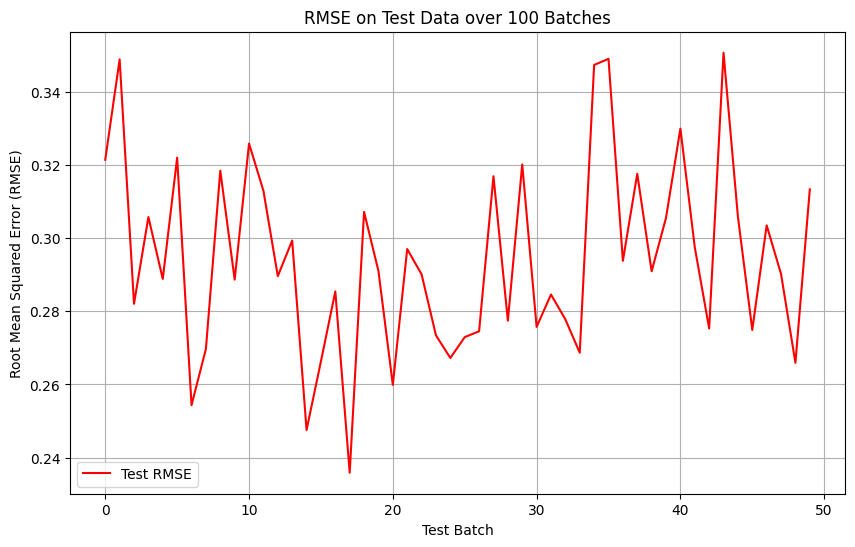

In [179]:
# Liste pour stocker les valeurs de RMSE
RMSE_list = []

# Running the TensorFlow session
with tf.Session(graph=graph) as sess:
    sess.run(init)

    # Initialize the summary for TensorBoard
    histogram_summary = tf.summary.scalar('MSE', loss)
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter('./graphs', sess.graph)

    # Training loop
    for iter in range(num_iter):

        # Get a batch of data from the generator
        x_batch, y_batch = next(generator)

        # Run the graph: Calculate the current loss and update parameters
        _, mse_value, summary = sess.run([train, loss, merged], feed_dict={x: x_batch, y: y_batch})

        # Calculate RMSE (square root of MSE)
        rmse_value = np.sqrt(mse_value)

        # Add the RMSE value to the list
        RMSE_list.append(rmse_value)

        # Write the summary for TensorBoard
        writer.add_summary(summary, iter)

        # Print the progress and RMSE value every 10 iterations
        if iter % 10 == 0: 
            print(f"Iteration {iter}/{num_iter}, RMSE: {rmse_value}")

    # Plotting the RMSE over iterations
    plt.figure(figsize=(10, 6))
    plt.plot(range(num_iter), RMSE_list, label="RMSE", color='b')
    plt.xlabel('Iteration')
    plt.ylabel('Root Mean Squared Error (RMSE)')
    plt.title('Evolution of RMSE over Iterations')
    plt.legend()
    plt.grid()
    plt.show()

    RMSE_test_list = []

    # Testing the model over 100 batches
    for i in range(50):
        # Get a batch of data for testing
        x_test, y_test = next(testgenerator)

        # Run the model to get predictions
        test_loss = sess.run(loss, feed_dict={x: x_test, y: y_test})

        # Calculate RMSE on the test batch
        rmse_test = np.sqrt(test_loss)

        # Add RMSE value to the test list
        RMSE_test_list.append(rmse_test)

        if i % 10 == 0:
            print(f"Test Batch {i+1}/100, RMSE: {rmse_test}")

    # Plotting the RMSE over test batches
    plt.figure(figsize=(10, 6))
    plt.plot(range(50), RMSE_test_list, label="Test RMSE", color='r')
    plt.xlabel('Test Batch')
    plt.ylabel('Root Mean Squared Error (RMSE)')
    plt.title('RMSE on Test Data over 100 Batches')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Reorganize the test data for final predictions
    ind = (len(x_test_scaled) // sequence_length)

    saver = tf.train.Saver()
    saver.save(sess, './my_trained_model')